In [161]:
# Import libraries and standardize path
import os
from pathlib import Path
import numpy as np
import cv2
from tkinter.filedialog import askopenfilename
import SimpleITK as sitk

In [162]:
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")
# Change directory as needed
#os.chdir("D:/Users/Jacks/Desktop/Jackson's Homework/Year 4/BMEG 457/MRI-TO-PCT/Capstone Code and resources")

Current working directory: D:\Users\Jacks\Desktop\Jackson's Homework\Year 4\BMEG 457\MRI-TO-PCT\Capstone Code and resources


In [ ]:
# Section for inverse log scaling + bias correction
image_path = "Images/chicken screenshot.png" # Change as needed

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Image at path '{image_path}' could not be loaded. Check the file path.")

image_sitk = sitk.GetImageFromArray(image)
image_sitk = sitk.Cast(image_sitk, sitk.sitkFloat32) # Need to cast to float to avoid uint8 errors

# Bias Field Correction (N4ITK)
corrector = sitk.N4BiasFieldCorrectionImageFilter()
corrected_image_sitk = corrector.Execute(image_sitk)

corrected_image = sitk.GetArrayFromImage(corrected_image_sitk)

log_image = np.log(corrected_image + 1) # Avoids log(0)
log_image = np.uint8(255 * log_image / np.max(log_image)) # Normalization from [0 - 1] within rescaling

inverse_log_image = 255 - log_image  
cv2.imwrite('Images/CFP_inverse_log_scaled_image.png', inverse_log_image) # Change as needed to avoid overwrite

True

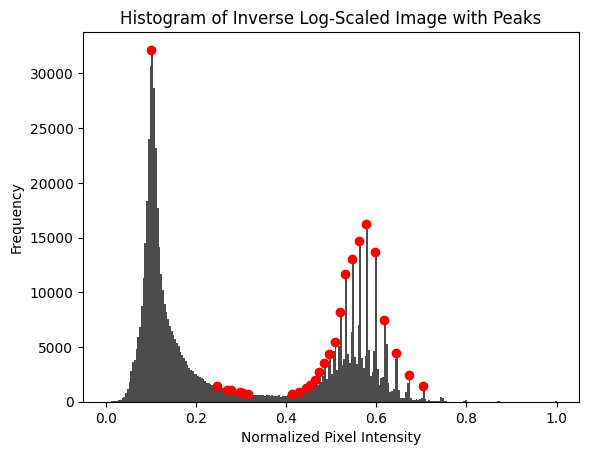

Thresholds for Peaks: [0.1015625  0.24609375 0.26953125 0.27734375 0.296875   0.3046875
 0.31640625 0.4140625  0.4296875  0.4453125  0.453125   0.46484375
 0.47265625 0.484375   0.49609375 0.5078125  0.51953125 0.53125
 0.546875   0.5625     0.578125   0.59765625 0.6171875  0.64453125
 0.671875   0.703125  ]


In [164]:
# Section for Histogram and Thresholding
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

inv_norm = inverse_log_image / 255.0

hist, bins = np.histogram(inv_norm.ravel(), bins=256, range=(0, 1))

#Change height to identify peaks 
peaks, _ = find_peaks(hist, height=700)

# Threshold values
thresholds = bins[peaks]

plt.hist(inv_norm.ravel(), bins=256, range=(0, 1), color='black', alpha=0.7)
plt.scatter(thresholds, hist[peaks], color='red', zorder=5)
plt.title('Histogram of Inverse Log-Scaled Image with Peaks')
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

print('Thresholds for Peaks:', thresholds)

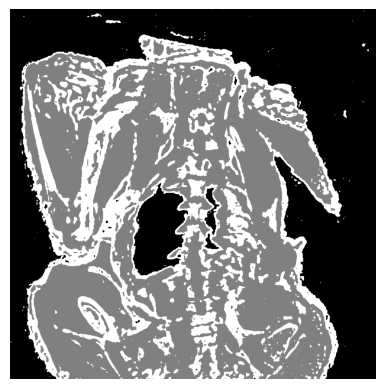

In [165]:
# Section for Segmentation based on Previous Thresholds
segmented_image = np.zeros_like(inverse_log_image, dtype=np.uint8)

# Manually choose thresholds based on above histogram bins and inverse log scaled image
threshold1 = 0.13 # or threshold[0] + 0.02, threshold[1], etc.
threshold2 = 0.4

# Segment the image based on thresholds (masking from literature) 
soft_tissue_mask = (inv_norm < threshold1) 
bone_mask = (inv_norm >= threshold1) & (inv_norm < threshold2)  
air_mask = (inv_norm >= threshold2) 

# Assign greyscale values for segment display
segmented_image[air_mask] = 0  
segmented_image[soft_tissue_mask] = 128 
segmented_image[bone_mask] = 255   

# Save and display
cv2.imwrite('Images/CFP_segmented_image.png', segmented_image)
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.show()